In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import glob
from scipy.interpolate import *
import matplotlib.cm as cm
import math
import scipy.optimize
import matplotlib
from joblib import dump,load
import pandas as pd
from decimal import Decimal
from astropy.io import fits
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pickle

CMAP = plt.cm.coolwarm
CMAP2 = plt.cm.viridis

In [4]:
%matplotlib inline
a_sol = 4.603e9
m_sol = 1.98847e30
m_ceres = 9.1e20
a_start = 2e9 #the age when starlifting starts

In [5]:
def get_output(fname):
    names = ['step', 'lg_Tmax', 'Teff', 'lg_LH', 'lg_Lnuc', 'mass', 'H_rich', 'H_cntr', 'N_cntr', 'Y_surf', 'eta_cntr', 'zones', 'retry',
             'lg_dt_yrs', 'lg_Tcntr', 'lg_R', 'lg_L3a', 'lg_Lneu', 'lg_Mdot', 'He_core', 'He_cntr', 'O_cntr', 'Z_surf', 'gam_cntr', 'iters',
             'age', 'lg_Dcntr', 'lg_L', 'lg_LZ', 'lg_Lphoto', 'lg_Dsurf', 'CO_core', 'C_cntr', 'Ne_cntr', 'Z_cntr', 'v_div_cs']
    try:
        f = open(fname, "r")
    except:
        print("NO FILE ", fname)
        return -1
    lines = f.readlines()
    step = 1
    grabbing=0
    data=[]
    for line in lines:
        if("finished" in line): data,step,grabbing = [],1,0
        ls=line.split()
        if(grabbing==0): temp=[]
        if(len(ls) >=1):
            if(ls[0] == str(step)): 
                grabbing +=1
                for i in ls: temp.append(float(i))
                #hcent = temp[-6]
                #if(hcent ==0.0): break
                step+=1
            elif(grabbing>0):
                if(grabbing ==2): ls = ls[:11]

                for  i in ls: temp.append(float(i))
                grabbing +=1
            if(grabbing == 3):
                grabbing = 0
                data.append(temp)

    df = pd.DataFrame(data,columns = names)
    if("best" in fname):
        temp_df = df[df["age"]>=a_start]
        if(len(temp_df)  == 0): 
            return df
        if("False" in fname): 
            log_L = np.power(10.0,np.array(temp_df["lg_L"]))*np.power(np.array(temp_df["mass"]),2.0)
            log_L_i = log_L[0]
            df = df[(df["age"]<=a_start) | (np.abs(np.power(10.0,df["lg_L"])*np.power(df["mass"],2.0)/log_L_i-1) < 0.01)]
        else:
            log_L = np.power(10.0,np.array(temp_df["lg_L"]))
            log_L_i = log_L[0]
            df = df[(df["age"]<=a_start) | (np.abs(np.power(10.0,df["lg_L"])/log_L_i-1) < 0.01)]
    
    return df

In [6]:
def get_all_dfs():
#     runs = glob.glob("output/*")
#     all_dfs,info=[],[]
#     for run in runs:
#         print(run)
#         for mass_dir in glob.glob(run+"/*"):
    runs = glob.glob("output/*")
    all_dfs,info=[],[]
    for run in runs:
        print(run)
        mass_dir = run
        z = float(mass_dir.split("_")[-1])
        m_i = float((mass_dir.split("_")[0]).split("M")[-1])
        if("True" in mass_dir.split("Isolum")[-1]): isolum=True
        else: isolum = False
        all_dfs.append(get_output(mass_dir+"/output_best.txt"))
        info.append(np.array([z, m_i, isolum, True]))
        all_dfs.append(get_output(mass_dir+"/output_full.txt"))
        info.append(np.array([z, m_i, isolum, False]))   

    return all_dfs, info
    
    
def select_df(all_dfs,info, z,m_i, isolum=True,best=True):
    all_z, all_m_i, all_iso, all_best = np.array(info).T
    
    if(best == False): isolum = False
    
    a = np.where(np.abs(np.array(all_z)-z) <0.001)[0]
    b = np.where(np.abs(np.array(all_m_i)-m_i) <0.001)[0]
    c = np.where(np.abs(np.array(all_iso)-float(isolum)) <0.001)[0]
    d = np.where(np.abs(np.array(all_best)-float(best)) <0.001)[0]
    ind = np.intersect1d(np.intersect1d(np.intersect1d(a, b), c), d)
    if(len(ind)>1):print("SELECTION ERROR")
    return all_dfs[ind[0]]
    
    

In [7]:
all_dfs, info = get_all_dfs()

output\M0.21_Isolum_False_zbase_0.000122
output\M0.21_Isolum_False_zbase_0.00122
output\M0.21_Isolum_False_zbase_0.0122
output\M0.21_Isolum_True_zbase_0.000122
NO FILE  output\M0.21_Isolum_True_zbase_0.000122/output_full.txt
output\M0.21_Isolum_True_zbase_0.00122
NO FILE  output\M0.21_Isolum_True_zbase_0.00122/output_full.txt
output\M0.21_Isolum_True_zbase_0.0122
NO FILE  output\M0.21_Isolum_True_zbase_0.0122/output_full.txt
output\M0.22_Isolum_False_zbase_0.000122
output\M0.22_Isolum_False_zbase_0.00122
output\M0.22_Isolum_False_zbase_0.0122
output\M0.22_Isolum_True_zbase_0.000122
NO FILE  output\M0.22_Isolum_True_zbase_0.000122/output_full.txt
output\M0.22_Isolum_True_zbase_0.00122
NO FILE  output\M0.22_Isolum_True_zbase_0.00122/output_full.txt
output\M0.22_Isolum_True_zbase_0.0122
NO FILE  output\M0.22_Isolum_True_zbase_0.0122/output_full.txt
output\M0.23_Isolum_False_zbase_0.000122
output\M0.23_Isolum_False_zbase_0.00122
output\M0.23_Isolum_False_zbase_0.0122
output\M0.23_Isolum_Tr

output\M0.3_Isolum_True_zbase_0.000122
NO FILE  output\M0.3_Isolum_True_zbase_0.000122/output_full.txt
output\M0.3_Isolum_True_zbase_0.00122
NO FILE  output\M0.3_Isolum_True_zbase_0.00122/output_full.txt
output\M0.3_Isolum_True_zbase_0.0122
NO FILE  output\M0.3_Isolum_True_zbase_0.0122/output_full.txt
output\M0.41_Isolum_False_zbase_0.000122
output\M0.41_Isolum_False_zbase_0.00122
output\M0.41_Isolum_False_zbase_0.0122
output\M0.41_Isolum_True_zbase_0.000122
NO FILE  output\M0.41_Isolum_True_zbase_0.000122/output_full.txt
output\M0.41_Isolum_True_zbase_0.00122
NO FILE  output\M0.41_Isolum_True_zbase_0.00122/output_full.txt
output\M0.41_Isolum_True_zbase_0.0122
NO FILE  output\M0.41_Isolum_True_zbase_0.0122/output_full.txt
output\M0.42_Isolum_False_zbase_0.000122
output\M0.42_Isolum_False_zbase_0.00122
output\M0.42_Isolum_False_zbase_0.0122
output\M0.42_Isolum_True_zbase_0.000122
NO FILE  output\M0.42_Isolum_True_zbase_0.000122/output_full.txt
output\M0.42_Isolum_True_zbase_0.00122
NO F

output\M0.5_Isolum_False_zbase_0.00122
output\M0.5_Isolum_False_zbase_0.0122
output\M0.5_Isolum_True_zbase_0.000122
NO FILE  output\M0.5_Isolum_True_zbase_0.000122/output_full.txt
output\M0.5_Isolum_True_zbase_0.00122
NO FILE  output\M0.5_Isolum_True_zbase_0.00122/output_full.txt
output\M0.5_Isolum_True_zbase_0.0122
NO FILE  output\M0.5_Isolum_True_zbase_0.0122/output_full.txt
output\M0.61_Isolum_False_zbase_0.000122
output\M0.61_Isolum_False_zbase_0.00122
output\M0.61_Isolum_False_zbase_0.0122
output\M0.61_Isolum_True_zbase_0.000122
NO FILE  output\M0.61_Isolum_True_zbase_0.000122/output_full.txt
output\M0.61_Isolum_True_zbase_0.00122
NO FILE  output\M0.61_Isolum_True_zbase_0.00122/output_full.txt
output\M0.61_Isolum_True_zbase_0.0122
NO FILE  output\M0.61_Isolum_True_zbase_0.0122/output_full.txt
output\M0.62_Isolum_False_zbase_0.000122
output\M0.62_Isolum_False_zbase_0.00122
output\M0.62_Isolum_False_zbase_0.0122
output\M0.62_Isolum_True_zbase_0.000122
NO FILE  output\M0.62_Isolum_Tr

output\M0.79_Isolum_True_zbase_0.000122
NO FILE  output\M0.79_Isolum_True_zbase_0.000122/output_full.txt
output\M0.79_Isolum_True_zbase_0.00122
NO FILE  output\M0.79_Isolum_True_zbase_0.00122/output_full.txt
output\M0.79_Isolum_True_zbase_0.0122
NO FILE  output\M0.79_Isolum_True_zbase_0.0122/output_full.txt
output\M0.7_Isolum_False_zbase_0.000122
output\M0.7_Isolum_False_zbase_0.00122
output\M0.7_Isolum_False_zbase_0.0122
output\M0.7_Isolum_True_zbase_0.000122
NO FILE  output\M0.7_Isolum_True_zbase_0.000122/output_full.txt
output\M0.7_Isolum_True_zbase_0.00122
NO FILE  output\M0.7_Isolum_True_zbase_0.00122/output_full.txt
output\M0.7_Isolum_True_zbase_0.0122
NO FILE  output\M0.7_Isolum_True_zbase_0.0122/output_full.txt
output\M0.81_Isolum_False_zbase_0.000122
output\M0.81_Isolum_False_zbase_0.00122
output\M0.81_Isolum_False_zbase_0.0122
output\M0.81_Isolum_True_zbase_0.000122
NO FILE  output\M0.81_Isolum_True_zbase_0.000122/output_full.txt
output\M0.81_Isolum_True_zbase_0.00122
NO FILE

NO FILE  output\M0.98_Isolum_True_zbase_0.00122/output_full.txt
output\M0.98_Isolum_True_zbase_0.0122
NO FILE  output\M0.98_Isolum_True_zbase_0.0122/output_full.txt
output\M0.99_Isolum_False_zbase_0.000122
output\M0.99_Isolum_False_zbase_0.00122
output\M0.99_Isolum_False_zbase_0.0122
output\M0.99_Isolum_True_zbase_0.000122
NO FILE  output\M0.99_Isolum_True_zbase_0.000122/output_full.txt
output\M0.99_Isolum_True_zbase_0.00122
NO FILE  output\M0.99_Isolum_True_zbase_0.00122/output_full.txt
output\M0.99_Isolum_True_zbase_0.0122
NO FILE  output\M0.99_Isolum_True_zbase_0.0122/output_full.txt
output\M0.9_Isolum_False_zbase_0.000122
output\M0.9_Isolum_False_zbase_0.00122
output\M0.9_Isolum_False_zbase_0.0122
output\M0.9_Isolum_True_zbase_0.000122
NO FILE  output\M0.9_Isolum_True_zbase_0.000122/output_full.txt
output\M0.9_Isolum_True_zbase_0.00122
NO FILE  output\M0.9_Isolum_True_zbase_0.00122/output_full.txt
output\M0.9_Isolum_True_zbase_0.0122
NO FILE  output\M0.9_Isolum_True_zbase_0.0122/ou

output\M1.18_Isolum_False_zbase_0.0122
output\M1.18_Isolum_True_zbase_0.000122
NO FILE  output\M1.18_Isolum_True_zbase_0.000122/output_full.txt
output\M1.18_Isolum_True_zbase_0.00122
NO FILE  output\M1.18_Isolum_True_zbase_0.00122/output_full.txt
output\M1.18_Isolum_True_zbase_0.0122
NO FILE  output\M1.18_Isolum_True_zbase_0.0122/output_full.txt
output\M1.19_Isolum_False_zbase_0.000122
output\M1.19_Isolum_False_zbase_0.00122
output\M1.19_Isolum_False_zbase_0.0122
output\M1.19_Isolum_True_zbase_0.000122
NO FILE  output\M1.19_Isolum_True_zbase_0.000122/output_full.txt
output\M1.19_Isolum_True_zbase_0.00122
NO FILE  output\M1.19_Isolum_True_zbase_0.00122/output_full.txt
output\M1.19_Isolum_True_zbase_0.0122
NO FILE  output\M1.19_Isolum_True_zbase_0.0122/output_full.txt
output\M1.1_Isolum_False_zbase_0.000122
output\M1.1_Isolum_False_zbase_0.00122
output\M1.1_Isolum_False_zbase_0.0122
output\M1.1_Isolum_True_zbase_0.000122
NO FILE  output\M1.1_Isolum_True_zbase_0.000122/output_full.txt
out

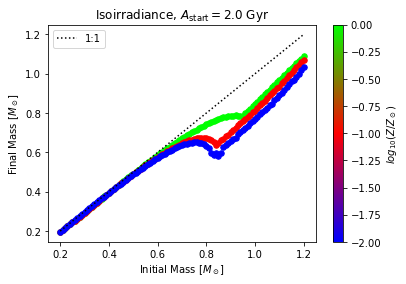

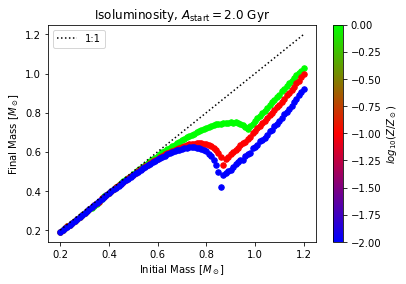

In [77]:
CMAP2 = plt.cm.brg
z_list = [0.0122, 0.00122, 0.000122]
for iso,marker in zip([False,True],["x", "+"]):
    plt.figure()
    plt.xlabel(r"Initial Mass $[M_\odot]$")
    plt.ylabel(r"Final Mass $[M_\odot]$")
    if(not iso): plt.title(r"Isoirradiance, $A_{\rm start}=2.0$ Gyr")
    else: plt.title(r"Isoluminosity, $A_{\rm start}=2.0$ Gyr")
    for z in z_list:  
        mass_range = np.linspace(0.2,1.2,101)
        flist, mlist, m2list = [],[],[]
        
        for m in mass_range:
            df = select_df(all_dfs, info, z, m, isolum = iso, best=True)
            final_age, init_mass = list(df["age"])[-1], list(df["mass"])[0]
            final_mass = list(df["mass"])[-1]
            flist.append(final_age)
            mlist.append(init_mass)
            m2list.append(final_mass)
        plt.scatter(mlist, m2list, color=CMAP2((np.log10((z)/(0.0122))+2)/2),s=30)

    plt.plot([0.2,1.2], [0.2,1.2],color="black", ls = "dotted",label="1:1")
    c = plt.scatter([0.2,0.2,0.2], [0.2,0.2,0.2], c=np.log10(np.array(z_list)/0.0122), cmap=CMAP2, s=0)   
    plt.colorbar(label=r"$log_{10}(Z/Z_\odot)$")
    plt.legend() 
    plt.savefig("figures/mi_vs_mf_iso="+str(iso)+".pdf",bbox_inches="tight")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


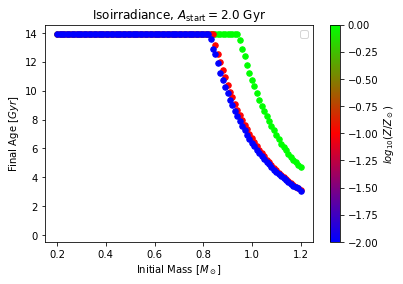

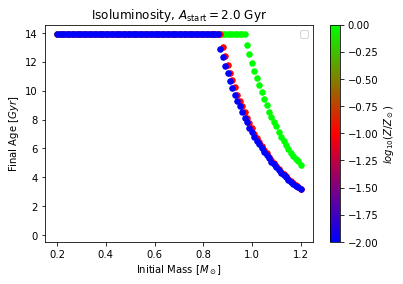

In [76]:
CMAP2 = plt.cm.brg
z_list = [0.0122, 0.00122, 0.000122]
for iso,marker in zip([False,True],["x", "+"]):
    plt.figure()
    plt.xlabel(r"Initial Mass $[M_\odot]$")
    plt.ylabel(r"Final Age $[Gyr]$")
    if(not iso): plt.title(r"Isoirradiance, $A_{\rm start}=2.0$ Gyr")
    else: plt.title(r"Isoluminosity, $A_{\rm start}=2.0$ Gyr")
    for z in z_list:  
        mass_range = np.linspace(0.2,1.2,101)
        flist, mlist, m2list = [],[],[]
        
        for m in mass_range:
            df = select_df(all_dfs, info, z, m, isolum = iso, best=True)
            final_age, init_mass = list(df["age"])[-1], list(df["mass"])[0]
            final_mass = list(df["mass"])[-1]
            flist.append(final_age)
            mlist.append(init_mass)
            m2list.append(final_mass)
        plt.scatter(mlist, np.array(flist)/1e9, color=CMAP2((np.log10((z)/(0.0122))+2)/2),s=30)

    #plt.plot([0.2,1.2], [0.2,1.2],color="black", ls = "dotted",label="1:1")
    c = plt.scatter([0.2,0.2,0.2], [0.2,0.2,0.2], c=np.log10(np.array(z_list)/0.0122), cmap=CMAP2, s=0)   
    plt.colorbar(label=r"$log_{10}(Z/Z_\odot)$")
    plt.legend() 
    plt.savefig("figures/mi_vs_tau_iso="+str(iso)+".pdf",bbox_inches="tight")

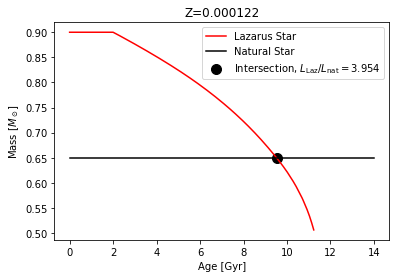

In [75]:
df = select_df(all_dfs, info, 0.000122, 0.9, isolum = True, best=True)
#plt.plot(df["age"], np.power(10,df["log_R"]))
plt.plot(np.array(df["age"])/1e9, df["mass"],label="Lazarus Star", color="red")
i = np.argmin(np.abs(np.array(df["mass"]) - 0.65))
l = np.array(df["lg_L"])[i]
a = np.array(df["age"])[i]

df = select_df(all_dfs, info, 0.000122, 0.65, isolum = True, best=False)
plt.plot(np.array(df["age"])/1e9, df["mass"], label="Natural Star", color="black")

i = np.argmin(np.abs(np.array(df["age"]) - a))
l2 = np.array(df["lg_L"])[i]
val = '%.3f'%(10**l/10**l2)
plt.scatter(np.array(df["age"])[i]/1e9, np.array(df["mass"])[i], c="black", marker="o", s=100, label="Intersection"+r", $L_{\rm Laz}/L_{\rm nat} =$"+str(val))
plt.legend()
plt.xlabel("Age [Gyr]")
plt.ylabel(r"Mass $[M_\odot]$")
plt.title("Z=0.000122")
plt.savefig("figures/l_ratio_ex.pdf",bbox_inches="tight")


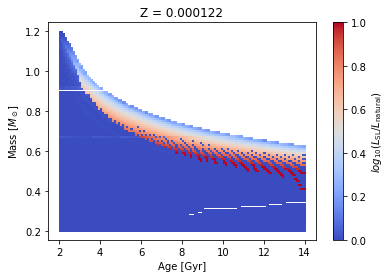

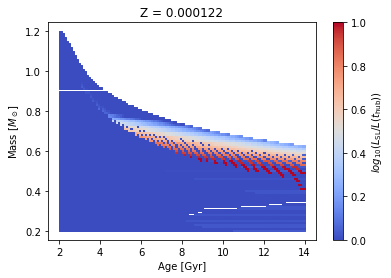

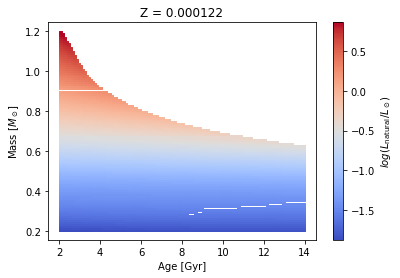

In [82]:
def get_max_l(all_dfs,info,metals):
    mass_range = np.linspace(0.2,1.2, 101)
    age_range  = np.linspace(2e9,14e9,121)
    dm, da = 0.05/2.0,0.5e9/2.0
    all_m, all_a, all_l = [],[],[]
    all_m2, all_a2, all_l2 = [],[],[]
    for mass_eval in mass_range:
            df = select_df(all_dfs, info, metals, mass_eval, isolum = True, best=True)
            all_m.extend(list(df["mass"]))
            all_a.extend(list(df["age"]))
            all_l.extend(list(df["lg_L"]))
            df2 = select_df(all_dfs, info, metals, mass_eval, isolum = True, best=False)
            all_m2.extend(list(df2["mass"]))
            all_a2.extend(list(df2["age"]))
            all_l2.extend(list(df2["lg_L"]))
    all_m, all_a, all_l = np.array(all_m), np.array(all_a), np.array(all_l)
    all_m2, all_a2, all_l2 = np.array(all_m2), np.array(all_a2), np.array(all_l2)

    mgrid,agrid,lgrid =[],[],[]
    lgrid2 =[]
    l_hub_list = []
    thub = 13e9
    for y in range(100):
        mup,mlow  = mass_range[y+1], mass_range[y]
        filt3 = np.where((all_m2 <= mup) & (all_m2 >= mlow) & (all_a2 <= thub) & (all_a2 >= 2e9))[0]
        l_hun = False
        if(np.size(filt3)>0):
            atemp = all_a2[filt3]
            ltemp = all_l2[filt3]
#             if(mup >0.65):
#                 print(atemp, ltemp, all_m2[filt3])
#                 return 1
            l_hub = ltemp[np.argmax(atemp)]

        for x in range(120):
            aup, alow = age_range[x+1], age_range[x]

            filt = np.where((all_m <= mup) & (all_m >= mlow) & (all_a <= aup) & (all_a >= alow))[0]
            filt2 = np.where((all_m2 <= mup) & (all_m2 >= mlow) & (all_a2 <= aup) & (all_a2 >= alow))[0]

            if(np.size(filt)>0 and np.size(filt2)>0):
                mgrid.append((mup+mlow)/2.0)
                agrid.append((aup+alow)/2.0)
                lgrid.append(10**np.max(all_l[filt]))
                lgrid2.append(10**np.max(all_l2[filt2]))
                l_hub_list.append(10**l_hub)
    lmax = lgrid
    l_natural = lgrid2
    return np.array(mgrid), np.array(agrid),np.array(lmax),np.array(l_natural),np.array(l_hub_list)
    
metals = 0.000122
mgrid, agrid,lmax,l_natural,l_hubble = get_max_l(all_dfs, info,metals)
plt.figure()
plt.title("Z = "+str(metals))
plt.scatter(agrid/1e9,mgrid,c=np.log10(lmax/l_natural),vmin=0,vmax=1,cmap=CMAP,marker='s',s=7)
plt.xlabel("Age [Gyr]")
plt.ylabel(r"Mass [$M_\odot$]")
plt.colorbar(label=r"$log_{10}(L_{\rm SL}/L_{\rm natural})$")
plt.savefig("figures/Lsl_vs_Lnatural_z_"+str(metals)+".pdf",bbox_inches="tight")

plt.figure()
plt.title("Z = "+str(metals))
plt.scatter(agrid/1e9,mgrid,c=np.log10(lmax/l_hubble),vmin=0,vmax=1,cmap=CMAP,marker='s',s=7)
plt.xlabel("Age [Gyr]")
plt.ylabel(r"Mass [$M_\odot$]")
plt.colorbar(label=r"$log_{10}(L_{\rm SL}/L(t_{\rm hub}))$")
plt.savefig("figures/Lsl_vs_Lhubble_z_"+str(metals)+".pdf",bbox_inches="tight")


plt.figure()
plt.title("Z = "+str(metals))
plt.scatter(agrid/1e9,mgrid,c=np.log10(l_natural),cmap=CMAP,marker='s',s=7)
plt.xlabel("Age [Gyr]")
plt.ylabel(r"Mass [$M_\odot$]")
plt.colorbar(label=r"$log(L_{\rm natural}/L_\odot)$")
plt.savefig("figures/Lnatural_z_"+str(metals)+".pdf",bbox_inches="tight")


In [154]:
points = np.array((agrid,mgrid)).T
values = l_natural

In [161]:
from scipy.interpolate import griddata
#l_natural_gaia= griddata(points, values, (a, m), method='nearest')
l_natural_grid= griddata(points, values, (a, m), method='nearest')



In [166]:
l_natural_grid

array([0.19836132, 0.22052661, 0.22733536, ..., 0.01898406, 0.497854  ,
       0.01861757])

# ML stuff


In [8]:
def get_ML_data(all_dfs, info, z_range=[0.0122,0.00122, 0.000122],params = ["age", "mass", "lg_L", "Teff", "lg_R"], isolum = True, isoirr = False, min_mass = -1, min_age= -1):

    X,y = [],[]
    mass_range =  np.linspace(0.2, 1.2,101)
    min_mass = 0.7
    params, z_range = np.array(params), np.array(z_range)

    best_list,iso_list = [False],[False]
    if(isolum): 
        best_list.append(True)
        iso_list.append(True)
    if(isoirr): 
        best_list.append(True)
        iso_list.append(False)

    for best,isolum in zip(best_list,iso_list):

        for z in z_range:
            for mass in mass_range:
                if(mass < min_mass): continue
                df_train = select_df(all_dfs, info, z, mass, isolum = isolum, best=best)
                all_data=[]
                for param in params:
                    all_data.append(np.array(df_train[param]))

                if("age" in params and "mass" in params): 
                    filt = np.where((all_data[np.where(params == 'age')[0][0]] > min_age) & (all_data[np.where(params == "mass")[0][0]] > min_mass))[0]
                elif("age" in params):
                    filt = np.where((all_data[np.where(params == "age")[0][0]] > min_age))[0]
                elif("mass" in params):
                    filt = np.where((all_data[np.where(params == "mass")[0][0]] > min_mass))[0]
                else: filt = np.where(all_data)[0]
                for x in range(len(all_data)):
                    all_data[x] = all_data[x][filt]
                all_data.append(np.log10(np.linspace(z,z,len(all_data[x]))))
                y_temp = np.linspace(float(best),float(best),len(all_data[0]))
                X_temp = np.array(all_data).T
                

                if(len(X) == 0):
                    X = X_temp
                    y = y_temp
                else:
                    X = np.concatenate((X,X_temp))
                    y = np.concatenate((y,y_temp))
    return X,y


def norm_data(X):
    new_X = []
    for list_ in X.T:
        lmax, lmin = np.max(list_), np.min(list_)
        dif = lmax-lmin
        if(np.abs(dif)<0.00001): dif = 1
        new_X.append((list_-lmin)/dif)
    X = np.array(new_X).T 
    return X

In [9]:
z_range = [0.0122,0.00122, 0.000122]
params = ["age", "mass", "lg_L", "Teff", "lg_R"]
min_mass, min_age = 0.5, 4e9
isoirr, isolum = True, True
X,y =  get_ML_data(all_dfs, info, z_range=z_range,params = params, isolum = isolum, isoirr = isoirr, min_mass = min_mass, min_age= min_age)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9,stratify=y, random_state=1)
clf = MLPClassifier(random_state=1, max_iter=10000,solver="adam").fit(X_train, y_train)
clf.predict_proba(X_test[:1])
print("Stratified score:",clf.score(X_test, y_test))
print(np.size(np.where(np.array(y_train == 1))[0])/np.size(y_train),", fraction of flagged stars in training set")
print(np.size(np.where(np.array(y_test == 1))[0])/np.size(y_test),", fraction of flagged stars in test set")
print(np.size(np.where(np.array(clf.predict(X_test) == 1))[0])/np.size(y_test),", fraction of flagged stars in predict set")


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=1)
clf = MLPClassifier(random_state=1, max_iter=10000,solver="adam").fit(X_train, y_train)
clf.predict_proba(X_test[:1])
print("No straification Score:",clf.score(X_test, y_test))
print(np.size(np.where(np.array(y_train == 1))[0])/np.size(y_train),", fraction of flagged stars in training set")
print(np.size(np.where(np.array(y_test == 1))[0])/np.size(y_test),", fraction of flagged stars in test set")
print(np.size(np.where(np.array(clf.predict(X_test) == 1))[0])/np.size(y_test),", fraction of flagged stars in predict set")




Stratified score: 0.8023626227767454
0.8023569669169162 , fraction of flagged stars in training set
0.8023626227767454 , fraction of flagged stars in test set
1.0 , fraction of flagged stars in predict set
No straification Score: 0.8026280860100876
0.8023274679567545 , fraction of flagged stars in training set
0.8026280860100876 , fraction of flagged stars in test set
1.0 , fraction of flagged stars in predict set


I test the exact same model except one stratifies the training/testing data (making the propotions of each flag equal in both sets) where one does not -- performance is massively different though the sets are large enough that the proportions are roughly the same anyway... What?

Oh it's flagging them as either 100% engineered or 100% natural. Try normalizing the data

In [14]:
z_range = [0.0122, 0.00122, 0.000122]
params = ["age", "mass", "lg_L", "Teff", "lg_R"]
min_mass, min_age = 0.5, 4e9
isoirr, isolum = True, True
X,y =  get_ML_data(all_dfs, info, z_range=z_range,params = params, isolum = isolum, isoirr = isoirr, min_mass = min_mass, min_age= min_age)

Xnorm = norm_data(X)

X_train, X_test, y_train, y_test = train_test_split(Xnorm, y, train_size=0.9,stratify=y, random_state=1)
clf = MLPClassifier(random_state=1, max_iter=10000,solver="adam").fit(X_train, y_train)
print("Stratified score:",clf.score(X_test, y_test))
print(np.size(np.where(np.array(y_train == 1))[0])/np.size(y_train),", fraction of flagged stars in training set")
print(np.size(np.where(np.array(y_test == 1))[0])/np.size(y_test),", fraction of flagged stars in test set")
print(np.size(np.where(np.array(clf.predict(X_test) == 1))[0])/np.size(y_test),", fraction of flagged stars in predict set")


X_train, X_test, y_train, y_test = train_test_split(Xnorm, y, train_size=0.9, random_state=1)
clf = MLPClassifier(random_state=1, max_iter=10000,solver="adam").fit(X_train, y_train)
print("No straification Score:",clf.score(X_test, y_test))
print(np.size(np.where(np.array(y_train == 1))[0])/np.size(y_train),", fraction of flagged stars in training set")
print(np.size(np.where(np.array(y_test == 1))[0])/np.size(y_test),", fraction of flagged stars in test set")
print(np.size(np.where(np.array(clf.predict(X_test) == 1))[0])/np.size(y_test),", fraction of flagged stars in predict set")




Stratified score: 0.9974780992832493
0.8023569669169162 , fraction of flagged stars in training set
0.8023626227767454 , fraction of flagged stars in test set
0.8048845234934962 , fraction of flagged stars in predict set
No straification Score: 0.9969471728165649
0.8023274679567545 , fraction of flagged stars in training set
0.8026280860100876 , fraction of flagged stars in test set
0.8056809131935228 , fraction of flagged stars in predict set


# Determing parameters the ML model is most sensitive to

# Fine tuning ML model

In [47]:
from itertools import combinations


global_param_list = ["mass","age", "lg_L", "Teff", "lg_R"]
z_range = [0.0122, 0.00122, 0.000122]
isoirr, isolum = True, True
X_list = []
X_train_list, X_test_list, y_train_list, y_test_list = [],[],[],[]

for x in range(2,6):

    combs = list(combinations([0,1, 2, 3,4], x))
    for comb in combs:
        params=[]
        for index in comb: params.append(global_param_list[index])

            
        X,y =  get_ML_data(all_dfs, info, z_range=z_range,params = params, isolum = isolum, isoirr = isoirr, min_mass = min_mass, min_age= min_age)
        Xnorm = norm_data(X)
        X_list.append(Xnorm)
        X_train, X_test, y_train, y_test = train_test_split(Xnorm, y, train_size=0.9, random_state=1)
        mlp = MLPClassifier(random_state=1, max_iter=1000)
        clf = mlp.fit(X_train, y_train)
        print("Score:",clf.score(X_test, y_test), "for combinations ", params)
        

Score: 0.9437217945314574 for combinations  ['mass', 'age']
Score: 0.7487249234954098 for combinations  ['mass', 'lg_L']
Score: 0.7446932530237529 for combinations  ['mass', 'Teff']
Score: 0.7494049642978579 for combinations  ['mass', 'lg_R']
Score: 0.9099654128837008 for combinations  ['age', 'lg_L']
Score: 0.9458495460440985 for combinations  ['age', 'Teff']
Score: 0.8561392131431041 for combinations  ['age', 'lg_R']
Score: 0.7609956661851317 for combinations  ['lg_L', 'Teff']
Score: 0.7609956661851317 for combinations  ['lg_L', 'lg_R']
Score: 0.7609956661851317 for combinations  ['Teff', 'lg_R']
Score: 0.9964162463498806 for combinations  ['mass', 'age', 'lg_L']
Score: 0.9761083089992036 for combinations  ['mass', 'age', 'Teff']
Score: 0.9952216617998407 for combinations  ['mass', 'age', 'lg_R']
Score: 0.7652402001262933 for combinations  ['mass', 'lg_L', 'Teff']
Score: 0.763442949434109 for combinations  ['mass', 'lg_L', 'lg_R']
Score: 0.7639772672074611 for combinations  ['mass', 

Horrible performance without age, which is unfortunate, but the good news it that we only need mass age and one of the others (which makes sense given the SB law). I'll focus on mass age and lum for now.

In [11]:
z_range = [0.0122, 0.00122, 0.000122]
#z_range = [0.0122]
params = ["mass","age", "lg_L"]
isoirr, isolum = False, True
X,y =  get_ML_data(all_dfs, info, z_range=z_range,params = params, isolum = isolum, isoirr = isoirr, min_mass = min_mass, min_age= min_age)

Xnorm = norm_data(X)
X_train, X_test, y_train, y_test = train_test_split(Xnorm, y, train_size=0.9, random_state=1)
mlp = MLPClassifier(random_state=1, max_iter=1000)
clf = mlp.fit(X_train, y_train)
print("Score before fine tuning:",clf.score(X_test, y_test))

Score before fine tuning: 0.9979484841577387


In [53]:
print("number of engineered stars in training set:", np.size(np.where(y_train==1)))
print("number of natural stars in training set:", np.size(np.where(y_train==0)))


number of engineered stars in training set: 26099
number of natural stars in training set: 13378


In [12]:
mlp.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [13]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (100,10,10), (100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam','sgd'],
    'alpha': [0.0001,0.001,0.00001],
    'learning_rate': ['constant'],
}
mlp = MLPClassifier(random_state=1, max_iter=1000)
clf2 = GridSearchCV(mlp, parameter_space, n_jobs=-1) #cv = num splits for cross val

#clf = mlp.fit(X_train, y_train)
clf2.fit(X_train, y_train)




print("Score after fine tuning:",clf2.score(X_test, y_test))

Score after fine tuning: 1.0


Saving the model

In [16]:
# filename = 'finalized_model.sav'
# pickle.dump(clf2, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
clf2 = pickle.load(open(filename, 'rb'))
result = clf2.score(X_test, y_test)
print(result)

1.0


So we can get a perfect prediction, but taking the original model and looking at how the prediction probability is distributed

C:\Users\Matthew\anaconda3\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


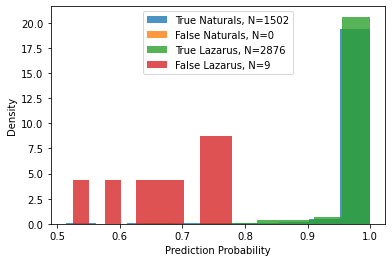

In [29]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

y0_good = np.where((y_pred == 0) & (y_test ==0))[0]
y0_bad = np.where((y_pred == 0) & (y_test ==1))[0]
y1_good = np.where((y_pred == 1) & (y_test == 1))[0]
y1_bad = np.where((y_pred == 1) & (y_test ==0))[0]

p0_true, p0_false = y_prob[y0_good].T[0], y_prob[y0_bad].T[0]
p1_true, p1_false = y_prob[y1_good].T[1], y_prob[y1_bad].T[1]
plt.hist(p0_true, alpha=0.8, density= True,label="True Naturals, N="+str(len(p0_true)))
plt.hist(p0_false, alpha=0.8, density= True,label="False Naturals, N="+str(len(p0_false)))
plt.hist(p1_true, alpha=0.8, density= True,label="True Lazarus, N="+str(len(p1_true)))
plt.hist(p1_false, alpha=0.8, density= True,label="False Lazarus, N="+str(len(p1_false)))
plt.ylabel("Density")
plt.xlabel("Prediction Probability")
plt.legend()
plt.savefig("figures/prediction_probability_model1.pdf",bbox_inches="tight")

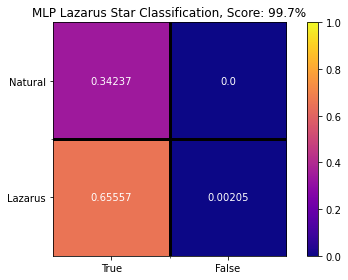

<Figure size 432x288 with 0 Axes>

In [30]:
size = np.size(y_test)
Z = [[np.size(y0_good)/size, np.size(y0_bad)/size],[np.size(y1_good)/size, np.size(y1_bad)/size]]
Z=np.array(Z)
dec=5
Z = np.trunc(Z*10**dec)/(10**dec)

xaxis = ["True", "False"]
yaxis = ["Natural", "Lazarus"]

fig, ax = plt.subplots()
im = ax.imshow(Z, cmap = cm.plasma,vmax=1)
plt.colorbar(im)

# We want to show all ticks...
ax.set_xticks(np.arange(len(xaxis)))
ax.set_yticks(np.arange(len(yaxis)))
# ... and label them with the respective list entries
ax.set_xticklabels(xaxis)
ax.set_yticklabels(yaxis)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(yaxis)):
    for j in range(len(xaxis)):
        text = ax.text(j, i, Z[i, j],
                       ha="center", va="center", color="w")
#ax.patch.set_edgecolor('black') 
ax.set_xticks([0.5], minor=True)
ax.set_yticks([0.5], minor=True)
ax.grid(which='minor', color='black', linewidth=3)

ax.set_title("MLP Lazarus Star Classification, Score: "+str(np.trunc(clf.score(X_test,y_test)*1000)/10)+"%")
fig.tight_layout()
plt.show()
plt.savefig("figures/prediction_distribution_model1.pdf",bbox_inches="tight")

C:\Users\Matthew\anaconda3\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


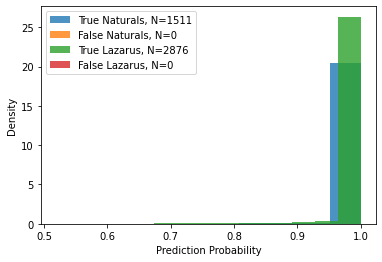

In [31]:
y_pred = clf2.predict(X_test)
y_prob = clf2.predict_proba(X_test)

y0_good = np.where((y_pred == 0) & (y_test ==0))[0]
y0_bad = np.where((y_pred == 0) & (y_test ==1))[0]
y1_good = np.where((y_pred == 1) & (y_test == 1))[0]
y1_bad = np.where((y_pred == 1) & (y_test ==0))[0]

p0_true, p0_false = y_prob[y0_good].T[0], y_prob[y0_bad].T[0]
p1_true, p1_false = y_prob[y1_good].T[1], y_prob[y1_bad].T[1]
plt.hist(p0_true, alpha=0.8, density= True,label="True Naturals, N="+str(len(p0_true)))
plt.hist(p0_false, alpha=0.8, density= True,label="False Naturals, N="+str(len(p0_false)))
plt.hist(p1_true, alpha=0.8, density= True,label="True Lazarus, N="+str(len(p1_true)))
plt.hist(p1_false, alpha=0.8, density= True,label="False Lazarus, N="+str(len(p1_false)))
plt.ylabel("Density")
plt.xlabel("Prediction Probability")
plt.legend()
plt.savefig("figures/prediction_probability_model2.pdf",bbox_inches="tight")

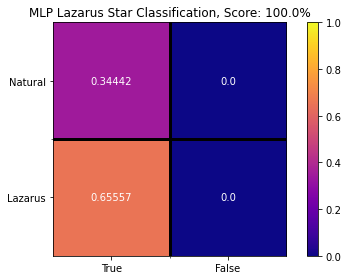

<Figure size 432x288 with 0 Axes>

In [32]:
size = np.size(y_test)
Z = [[np.size(y0_good)/size, np.size(y0_bad)/size],[np.size(y1_good)/size, np.size(y1_bad)/size]]
Z=np.array(Z)
dec=5
Z = np.trunc(Z*10**dec)/(10**dec)

xaxis = ["True", "False"]
yaxis = ["Natural", "Lazarus"]

fig, ax = plt.subplots()
im = ax.imshow(Z, cmap = cm.plasma,vmax=1)
plt.colorbar(im)

# We want to show all ticks...
ax.set_xticks(np.arange(len(xaxis)))
ax.set_yticks(np.arange(len(yaxis)))
# ... and label them with the respective list entries
ax.set_xticklabels(xaxis)
ax.set_yticklabels(yaxis)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(yaxis)):
    for j in range(len(xaxis)):
        text = ax.text(j, i, Z[i, j],
                       ha="center", va="center", color="w")
#ax.patch.set_edgecolor('black') 
ax.set_xticks([0.5], minor=True)
ax.set_yticks([0.5], minor=True)
ax.grid(which='minor', color='black', linewidth=3)

ax.set_title("MLP Lazarus Star Classification, Score: "+str(np.trunc(clf2.score(X_test,y_test)*1000)/10)+"%")
fig.tight_layout()
plt.show()
plt.savefig("figures/prediction_distribution_model2.pdf",bbox_inches="tight")

# GAIA DATA

In [33]:
# matchedfile = 'Fits_Files/allstar_HugeTable.fits'
# giant_catalog = fits.open(matchedfile)
# print(giant_catalog[1].columns.names)

# matchedfile = 'all_columns_catalog.fits'
# giant_catalog = fits.open(matchedfile)
# for name in giant_catalog[1].columns.names:
#     print(name)

# list(df.columns)
gp = glob.glob("gaia_params/*")
df_list = []

for ind,f in enumerate(gp):
    
    print(ind/len(gp))
    #names = ["teff","z", "lum","mass", "age", "stage"]

    df = pd.read_csv(f,comment='#', usecols=["teff_gspphot","mh_gspphot","radius_gspphot","lum_flame", "mass_flame", "age_flame","evolstage_flame"])
    #df = df[["teff_gspphot","mh_gspphot", "lum_flame", "mass_flame", "age_flame","evolstage_flame"]]
    df = df.dropna()
    df = df[df["mass_flame"]<=1.2]
    df = df[df["mass_flame"]>=0.2]
    df = df[df["age_flame"]>=2]
    df = df[df["mh_gspphot"] >= -2]
    df = df[df["mh_gspphot"] <=0]
    #df["mh_gspphot"] = np.power(10,np.array(df["mh_gspphot"]))*0.0122
    df= df[df["evolstage_flame"] >= 100]
    df= df[df["evolstage_flame"] <= 360]
    df["age_flame"] = np.array(df["age_flame"]*1e9)
    df["lum_flame"] = np.array(np.log10(df["lum_flame"]))
    df["radius_gspphot"] = np.array(np.log10(df["radius_gspphot"]))
    
    

    df_list.append(df)
df = pd.concat(df_list)


df_gaia = df

0.0
0.2
0.4
0.6
0.8


In [35]:

gaia_mass, gaia_age, gaia_lg_L = np.array(df_gaia["mass_flame"]),np.array(df_gaia["age_flame"]), np.array(df_gaia["lum_flame"]), 
gaia_teff, gaia_radius, gaia_z = np.array(df_gaia["teff_gspphot"]), np.array(df_gaia["radius_gspphot"]), np.array(df_gaia["mh_gspphot"])


lower_mass, upper_mass = np.min(X.T[0]), np.max(X.T[0])
lower_age, upper_age = np.min(X.T[1]), np.max(X.T[1])
lower_z, upper_z = np.min(X[3]), np.max(X[3])
gaia_filter = np.where((gaia_mass >= lower_mass) & (gaia_mass <=upper_mass) & (gaia_age >= lower_age) & (gaia_age <= upper_age) & (gaia_z >= lower_z) & (gaia_z <= upper_z))[0]

gaia_mass, gaia_age, gaia_lg_L = gaia_mass[gaia_filter], gaia_age[gaia_filter], gaia_lg_L[gaia_filter]
gaia_teff, gaia_radius, gaia_z = gaia_teff[gaia_filter], gaia_radius[gaia_filter], gaia_z[gaia_filter]


#X_predict = np.array((l1,l2,l3,l4,l5,l6)).T
X_gaia = np.array((gaia_mass,gaia_age,gaia_lg_L,gaia_z)).T
Xnorm_gaia = norm_data(X_gaia)

In [48]:
print(Xnorm[0])
print(Xnorm_gaia[0])

[0.01999216 0.00919018 0.0125359  1.        ]
[0.58177805 0.40724355 0.71764662 0.635109  ]


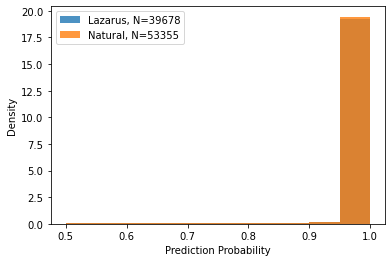

In [49]:
gaia_predict = clf.predict(Xnorm_gaia)
gaia_prob = clf.predict_proba(Xnorm_gaia)
gaia_laz = np.where(gaia_predict == 1)[0]
gaia_nat = np.where(gaia_predict == 0)[0]
plt.hist(gaia_prob[gaia_laz].T[1], alpha=0.8, label="Lazarus, N="+str(len(gaia_laz)), density=True)
plt.hist(gaia_prob[gaia_nat].T[0], alpha=0.8, label="Natural, N="+str(len(gaia_nat)), density=True)
plt.ylabel("Density")
plt.xlabel("Prediction Probability")
plt.legend()
plt.savefig("figures/gaia_prob_prediction_model1.pdf", bbox_inches="tight")

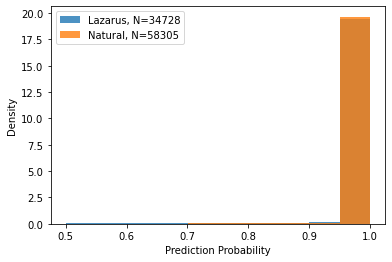

In [50]:
gaia_predict = clf2.predict(Xnorm_gaia)
gaia_prob = clf2.predict_proba(Xnorm_gaia)
gaia_laz = np.where(gaia_predict == 1)[0]
gaia_nat = np.where(gaia_predict == 0)[0]
plt.hist(gaia_prob[gaia_laz].T[1], alpha=0.8, label="Lazarus, N="+str(len(gaia_laz)), density=True)
plt.hist(gaia_prob[gaia_nat].T[0], alpha=0.8, label="Natural, N="+str(len(gaia_nat)), density=True)
plt.ylabel("Density")
plt.xlabel("Prediction Probability")
plt.legend()
plt.savefig("figures/gaia_prob_prediction_model2.pdf", bbox_inches="tight")

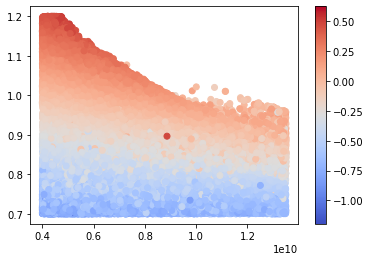

In [109]:
gaia_mass, gaia_age, gaia_lg_L

plt.scatter(gaia_age, gaia_mass, c=gaia_lg_L,cmap=CMAP)
plt.colorbar()